# Tugas 2 — Regresi Logistik (Biner) & Regresi Softmax (Multikelas)
**Dataset:** UCI Glass Identification  
**Poin Utama:** Stratified split, feature scaling (fit di train → apply ke test), model logistik biner & softmax, metrik (Accuracy, Precision, Recall, F1), serta grafik analisis.

---

In [1]:
import os, zipfile, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)

plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True

zip_path = '/home/wgg/proyek-jupyter/Tugas PMA/glass+identification.zip'
assert os.path.exists(zip_path), "File ZIP dataset tidak ditemukan di /mnt/data/"

with zipfile.ZipFile(zip_path, 'r') as z:
    names = z.namelist()
    candidate = None
    for n in names:
        ln = n.lower()
        if ('glass' in ln) and (ln.endswith('.data') or ln.endswith('.csv') or ln.endswith('.txt')):
            candidate = n
            break
    if candidate is None:
        candidate = names[0]
    data_bytes = z.read(candidate)
    data_stream = io.BytesIO(data_bytes)

colnames = ["Id","RI","Na","Mg","Al","Si","K","Ca","Ba","Fe","Type"]
try:
    df = pd.read_csv(data_stream, header=None, names=colnames)
except Exception:
    data_stream.seek(0)
    df = pd.read_csv(data_stream, header=None, names=colnames, sep=',', engine='python')

df = df.dropna().reset_index(drop=True)

X = df[["RI","Na","Mg","Al","Si","K","Ca","Ba","Fe"]].values
y = df["Type"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

from collections import Counter
counts = Counter(y_train)
majority_class = max(counts, key=counts.get)
y_train_bin = (y_train == majority_class).astype(int)
y_test_bin  = (y_test  == majority_class).astype(int)

logreg_bin = LogisticRegression(max_iter=2000, solver='lbfgs')
logreg_bin.fit(X_train_sc, y_train_bin)
y_pred_bin = logreg_bin.predict(X_test_sc)
y_prob_bin = logreg_bin.predict_proba(X_test_sc)[:,1]

acc_b  = accuracy_score(y_test_bin, y_pred_bin)
prec_b = precision_score(y_test_bin, y_pred_bin, zero_division=0)
rec_b  = recall_score(y_test_bin, y_pred_bin, zero_division=0)
f1_b   = f1_score(y_test_bin, y_pred_bin, zero_division=0)

cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

fpr, tpr, _ = roc_curve(y_test_bin, y_prob_bin)
roc_auc = auc(fpr, tpr)

softmax_clf = LogisticRegression(max_iter=5000, multi_class='multinomial', solver='lbfgs')
softmax_clf.fit(X_train_sc, y_train)

y_pred_multi = softmax_clf.predict(X_test_sc)
y_proba_multi = softmax_clf.predict_proba(X_test_sc)

acc_m  = accuracy_score(y_test, y_pred_multi)
prec_m = precision_score(y_test, y_pred_multi, average='macro', zero_division=0)
rec_m  = recall_score(y_test, y_pred_multi, average='macro', zero_division=0)
f1_m   = f1_score(y_test, y_pred_multi, average='macro', zero_division=0)

import numpy as np
labels_sorted = np.sort(np.unique(y_test))
cm_multi = confusion_matrix(y_test, y_pred_multi, labels=labels_sorted)

summary = pd.DataFrame({
    "Model": ["Logistic (Binary)", "Softmax (Multiclass)"],
    "Accuracy": [acc_b, acc_m],
    "Precision": [prec_b, prec_m],
    "Recall": [rec_b, rec_m],
    "F1-Score": [f1_b, f1_m]
})
print(summary)

                  Model  Accuracy  Precision    Recall  F1-Score
0     Logistic (Binary)  0.627907   0.000000  0.000000  0.000000
1  Softmax (Multiclass)  0.720930   0.650794  0.730159  0.684005


/home/wgg/proyek-jupyter/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


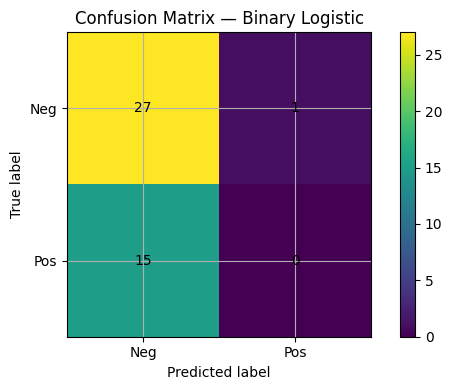

In [2]:
# Confusion Matrix - Binary
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(cm_bin, interpolation='nearest')
plt.title("Confusion Matrix — Binary Logistic")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Neg','Pos'])
plt.yticks(tick_marks, ['Neg','Pos'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
for i in range(cm_bin.shape[0]):
    for j in range(cm_bin.shape[1]):
        plt.text(j, i, cm_bin[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

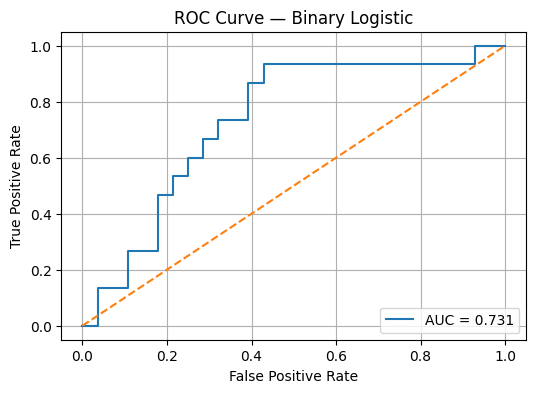

In [3]:
# ROC Curve - Binary
fig = plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Binary Logistic")
plt.legend(loc="lower right")
plt.show()

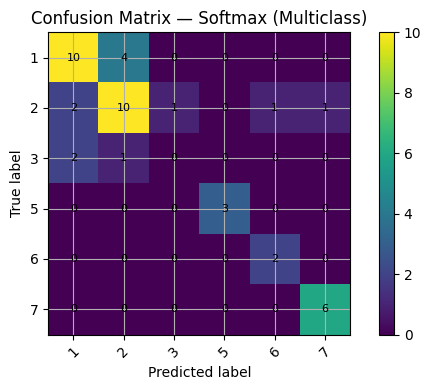

In [4]:
# Confusion Matrix - Multiclass
fig = plt.figure()
plt.imshow(cm_multi, interpolation='nearest')
plt.title("Confusion Matrix — Softmax (Multiclass)")
plt.colorbar()
tick_marks = np.arange(len(labels_sorted))
plt.xticks(tick_marks, labels_sorted, rotation=45)
plt.yticks(tick_marks, labels_sorted)
plt.xlabel('Predicted label')
plt.ylabel('True label')
for i in range(cm_multi.shape[0]):
    for j in range(cm_multi.shape[1]):
        plt.text(j, i, cm_multi[i, j], ha="center", va="center", fontsize=8)
plt.tight_layout()
plt.show()

## Catatan Teoretis (Singkat)
- **Binary Cross-Entropy (Log Loss)** untuk klasifikasi biner lebih tepat dibanding **MSE** karena memodelkan probabilitas dan memberikan gradien yang informatif saat prediksi mendekati 0/1.
- **Sigmoid vs Softmax:** Sigmoid mengubah skor menjadi probabilitas **independen** per kelas (umumnya biner), sedangkan Softmax memetakan vektor skor menjadi distribusi probabilitas **yang jumlahnya = 1** (kompetitif antarkelas).
- **Skala fitur** penting agar optimisasi (LBFGS) stabil dan tiap fitur berkontribusi proporsional.